## ... playpen..


### imports etc

In [1]:
# imports
import pandas as pd
import numpy as np
from scipy import stats

import collections
import sklearn
from sklearn import preprocessing as pp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)

import sys
import tensorflow as tf
import time
import os
import os.path
import pickle
import pyfolio as pf
import quandl

import logging as log
log.basicConfig(level=log.DEBUG,format='%(asctime)s %(name)s (%(levelname)s): %(message)s')

# load simple trading simulator
#import sim 
#import tf_models

In [2]:
#execfile('sim_fut.py')

quandl.ApiConfig.api_key = os.environ['QUANDL_AUTH']

### pull data

In [3]:
SP_FUTS_QCODE  = 'CHRIS/CME_ES'   # s&p futures
VIX_FUTS_QCODE = 'CHRIS/CBOE_VX'  # volatility futures
GC_FUTS_QCODE  = 'CHRIS/CME_GC'   # gold futures
CL_FUTS_QCODE  = 'CHRIS/CME_CL'   # crude futures
TU_FUTS_QCODE  = 'CHRIS/CME_TU'   # two-year futures
TY_FUTS_QCODE  = 'CHRIS/CME_TY'   # ten-year futures
VIX_QCODE      = 'CBOE/VIX'       # vix index 
VVIX_QCODE     = 'CBOE/VVIX'      # vvix index
VXV_QCODE      = 'CBOE/VXV'       # vxv index
SPY_QCODE      = 'GOOG/NYSE_SPY'  # SPY ETF

In [4]:
sp1 = quandl.get(SP_FUTS_QCODE+'1')
vx2 = quandl.get(VIX_FUTS_QCODE+'2')
gc1 = quandl.get(GC_FUTS_QCODE+'1')
cl1 = quandl.get(CL_FUTS_QCODE+'1')
tu1 = quandl.get(TU_FUTS_QCODE+'1')
ty1 = quandl.get(TY_FUTS_QCODE+'1')
vix = quandl.get(VIX_QCODE)
vvix = quandl.get(VVIX_QCODE)
vxv = quandl.get(VXV_QCODE)
spy = quandl.get(SPY_QCODE)


2017-02-13 09:58:03,716 requests.packages.urllib3.connectionpool (DEBUG): Starting new HTTPS connection (1): www.quandl.com
2017-02-13 09:58:04,677 requests.packages.urllib3.connectionpool (DEBUG): https://www.quandl.com:443 "GET /api/v3/datasets/CHRIS/CME_ES1/data?order=asc HTTP/1.1" 200 None
2017-02-13 09:58:05,860 requests.packages.urllib3.connectionpool (DEBUG): Starting new HTTPS connection (1): www.quandl.com
2017-02-13 09:58:06,530 requests.packages.urllib3.connectionpool (DEBUG): https://www.quandl.com:443 "GET /api/v3/datasets/CHRIS/CBOE_VX2/data?order=asc HTTP/1.1" 200 None
2017-02-13 09:58:07,286 requests.packages.urllib3.connectionpool (DEBUG): Starting new HTTPS connection (1): www.quandl.com
2017-02-13 09:58:09,225 requests.packages.urllib3.connectionpool (DEBUG): https://www.quandl.com:443 "GET /api/v3/datasets/CHRIS/CME_GC1/data?order=asc HTTP/1.1" 200 None
2017-02-13 09:58:11,654 requests.packages.urllib3.connectionpool (DEBUG): Starting new HTTPS connection (1): www.q

### visualize prices

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1997-09-09,934.0,942.0,933.0,934.0,NaN,934.0,7034.0,1109.0
1997-09-10,934.0,935.0,915.0,915.0,NaN,915.0,11387.0,2325.0
1997-09-11,916.0,918.0,900.0,908.0,NaN,908.0,2523.0,2549.0
1997-09-12,908.0,926.0,904.0,924.0,NaN,924.0,928.0,2163.0
1997-09-15,925.0,930.0,920.0,922.0,NaN,922.0,208.0,2107.0


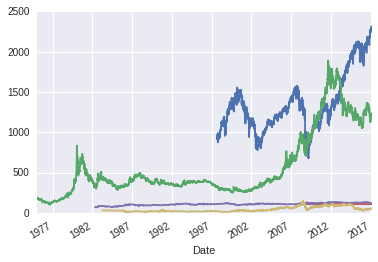

In [5]:
%matplotlib inline 
#%matplotlib notebook
sp1.Settle.plot()
gc1.Settle.plot()
tu1.Settle.plot()
ty1.Settle.plot()
cl1.Settle.plot()
sp1.head()

### calculate returns & navs, scale and revisualize

In [6]:

Returns = pd.DataFrame( {'es':np.log( sp1.Settle/sp1.Settle.shift() ),
                         'tu':np.log(tu1.Settle/tu1.Settle.shift() ),
                         'ty':np.log(ty1.Settle/ty1.Settle.shift() ),
                         'vx2':np.log(vx2.Settle/vx2.Settle.shift() ),
                         #'cl':np.log(cl1.Settle/cl1.Settle.shift() ),
                         'gc':np.log(gc1.Settle/gc1.Settle.shift() ) })
Returns = Returns[Returns.index>'2008-01-01']

print Returns.describe()
print Returns.head()
print tu1.head()
print ty1.head()

                es           gc           tu           ty          vx2
count  2331.000000  2282.000000  2276.000000  2299.000000  2295.000000
mean      0.000192     0.000170     0.000014     0.000042    -0.000258
std       0.013517     0.012509     0.000931     0.004144     0.038959
min      -0.104003    -0.098206    -0.009252    -0.026267    -0.185679
25%      -0.004449    -0.005612    -0.000285    -0.002199    -0.021435
50%       0.000727     0.000233     0.000000     0.000131    -0.003534
75%       0.005663     0.006745     0.000355     0.002372     0.017519
max       0.132022     0.086250     0.007809     0.035369     0.227390
                  es        gc        tu        ty       vx2
2008-01-02 -0.012774  0.025914  0.004825  0.008780  0.012326
2008-01-03  0.000171  0.010526  0.000814 -0.000410  0.001224
2008-01-04 -0.024813 -0.003920  0.001922  0.005587  0.031315
2008-01-07 -0.001055 -0.004283 -0.000739  0.001494 -0.019558
2008-01-08 -0.017386  0.021007  0.000000  0.000000  0.04

es     0.214533
gc     0.198523
tu     0.014774
ty     0.065769
vx2    0.618322
dtype: float64
es      4.661295
gc      5.037189
tu     67.688745
ty     15.204762
vx2     1.617280
dtype: float64


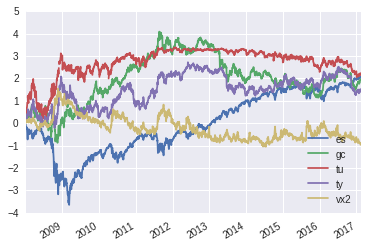

In [7]:
SD = np.sqrt(252) * Returns.apply(np.std ,0)
print SD
R = Returns.apply(np.mean ,0)

#SD.plot.bar()
#R.plot.bar()

# let's normalize everyone to 1 sigma and plot
M = 1/SD 
print M
RS = Returns * M

pd.DataFrame(np.cumsum(RS)).plot()

strategy sharpe:  0.28758490987
strategy ret:  0.05167656935
strategy vol:  0.179691519188
es sharpe:  0.225886354417
es ret:  0.0484600044784
es vol:  0.214532677742


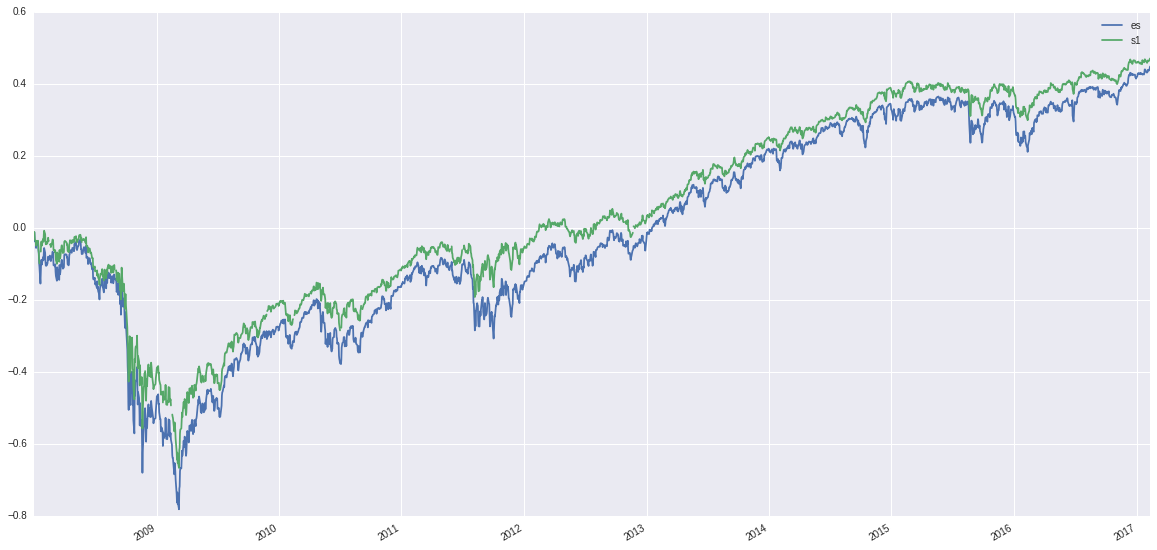

In [8]:
Returns.head()

s1 =  ( 1.0 * Returns.es) + ( 0.1 * Returns.vx2 ) #+ ( .1 * Returns.gc ) + (4 * Returns.tu ) + (2* Returns.ty)

df = pd.DataFrame({ 's1':np.cumsum(s1),'es':np.cumsum(Returns.es)})
#df['s_e'] = df.s1 - df.es
df.plot(figsize=[20,10])

df.head()

def sharpe(Returns) :
    return (np.sqrt(252) * np.mean(Returns))/np.std(Returns)

print 'strategy sharpe: ', sharpe(s1)
print 'strategy ret: ', 252 * np.mean(s1)
print 'strategy vol: ', np.sqrt(252) * np.std(s1)

print 'es sharpe: ',sharpe(Returns.es)
print 'es ret: ', 252 * np.mean(Returns.es)
print 'es vol: ', np.sqrt(252) * np.std(Returns.es)


### let's prep for the simulator

In [9]:
vx2=vx2.drop('EFP',axis=1)
vx2.rename(columns={'Total Volume': 'Volume'}, inplace=True)
vx2.rename(columns={'Prev. Day Open Interest': 'Previous Day Open Interest'}, inplace=True)

In [10]:
import sim

sp1['Sym'] = 'ES1';
vx2['Sym'] = 'VX2';
gc1['Sym'] = 'GC1';
tu1['Sym'] = 'TU1';
ty1['Sym'] = 'TY1';

sp1['Multiplier'] = 50.0;
vx2['Multiplier'] = 1000.0;
gc1['Multiplier'] = 100.0;
tu1['Multiplier'] = 2000.0;
ty1['Multiplier'] = 1000.0;

SIM_COLS = ['Sym', 'Open', 'High', 'Low', 'Settle', 'Volume','OI','Multiplier']

all = pd.concat( [sp1, vx2, gc1,tu1,ty1],axis=0 ) 
all = all[all.index >= '2008-01-01']
all.drop(['Change','Close'],inplace=True, axis=1)
all.rename(columns={'Previous Day Open Interest':'OI'},inplace=True)
all = all[SIM_COLS]
all.sort_index(inplace=True)

all.head()


,Sym,Open,High,Low,Settle,Volume,OI,Multiplier
2008-01-02,ES1,1478.750000,1482.750000,1449.000000,1458.500000,1614073.0,1764399.0,50.0
2008-01-02,TU1,105.164062,105.507812,105.140625,105.507812,6243.0,974024.0,2000.0
2008-01-02,GC1,837.500000,864.900000,837.500000,860.000000,48304.0,283927.0,100.0
2008-01-02,TY1,113.390625,114.437500,113.250000,114.390625,825858.0,2121399.0,1000.0
2008-01-02,VX2,23.980000,24.830000,23.980000,24.490000,654.0,13125.0,1000.0


In [11]:
S = sim.squarem(all)
S.drop(['Open','High','Low'],inplace=True)
S.rename(columns={'Settle':'Close'},inplace=True)

2017-02-13 09:58:28,977 root (INFO): Got rid of 0/5 symbols


In [12]:
Lookback_Days = 20
U=S
#U['ADV'] = U.groupby('Sym')['Volume'].apply(rolling(min_periods=1, window=Lookback_Days, center=False).mean())
U['Return'] = U.groupby('Sym')['Close'].pct_change()
U['Fwd_Close'] = U.groupby('Sym')['Close'].shift(-1)
U['Fwd_Return'] = U.groupby('Sym')['Return'].shift(-1)
U['SD'] = U.groupby('Sym')['Return'].apply(pd.rolling_std, Lookback_Days, 1).shift()

U=U.dropna()
U = U.sort_index()
U.head()

/usr/lib64/python2.7/site-packages/pandas/core/groupby.py:685: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=20,center=False).std()
  return func(g, *args, **kwargs)


,Sym,Open,High,Low,Close,Volume,OI,Multiplier,Return,Fwd_Close,Fwd_Return,SD
2008-01-07,ES1,1422.500000,1432.25000,1410.00000,1421.50000,2436934.0,1884889.0,50.0,-0.001054,1397.00000,-0.017235,0.017450
2008-01-07,TU1,105.718750,105.78125,105.65625,105.71875,7350.0,1013329.0,2000.0,-0.000738,105.71875,0.000000,0.000784
2008-01-07,GC1,862.800000,867.80000,857.80000,862.00000,122758.0,291209.0,100.0,-0.004274,880.30000,0.021230,0.010248
2008-01-07,VX2,24.780000,25.25000,24.59000,24.81000,473.0,13479.0,1000.0,-0.019368,25.90000,0.043934,0.021627
2008-01-07,TY1,114.796875,115.18750,114.68750,115.15625,1084444.0,2278155.0,1000.0,0.001495,115.15625,0.000000,0.004251


In [13]:
U2 = U[U.index < '2010-01-01']
U2 = U2[U2.index>'2008-01-01']
#U2 = U2[U2.Sym != 'VX2']
U2.head()
U2.tail()


,Sym,Open,High,Low,Close,Volume,OI,Multiplier,Return,Fwd_Close,Fwd_Return,SD
2009-12-31,TY1,115.671875,115.671875,115.046875,115.453125,315230.0,1209286.0,1000.0,-0.003372,115.531250,0.000677,0.005250
2009-12-31,ES1,1121.750000,1125.250000,1109.750000,1110.750000,638861.0,2392916.0,50.0,-0.010027,1128.750000,0.016205,0.005932
2009-12-31,VX2,24.900000,25.750000,24.850000,25.800000,2390.0,11862.0,1000.0,0.029940,24.850000,-0.036822,0.030338
2009-12-31,GC1,1094.100000,1107.600000,1093.100000,1096.200000,91654.0,319179.0,100.0,0.003387,1118.300000,0.020161,0.013388
2009-12-31,TU1,108.718750,108.804688,108.718750,108.718750,2539.0,6213.0,2000.0,-0.000790,108.257812,-0.004240,0.000871


2017-02-13 09:58:44,838 root (INFO): ran over [2008-01-07 - 2009-12-31] 514 days and 514 rows in 15 secs


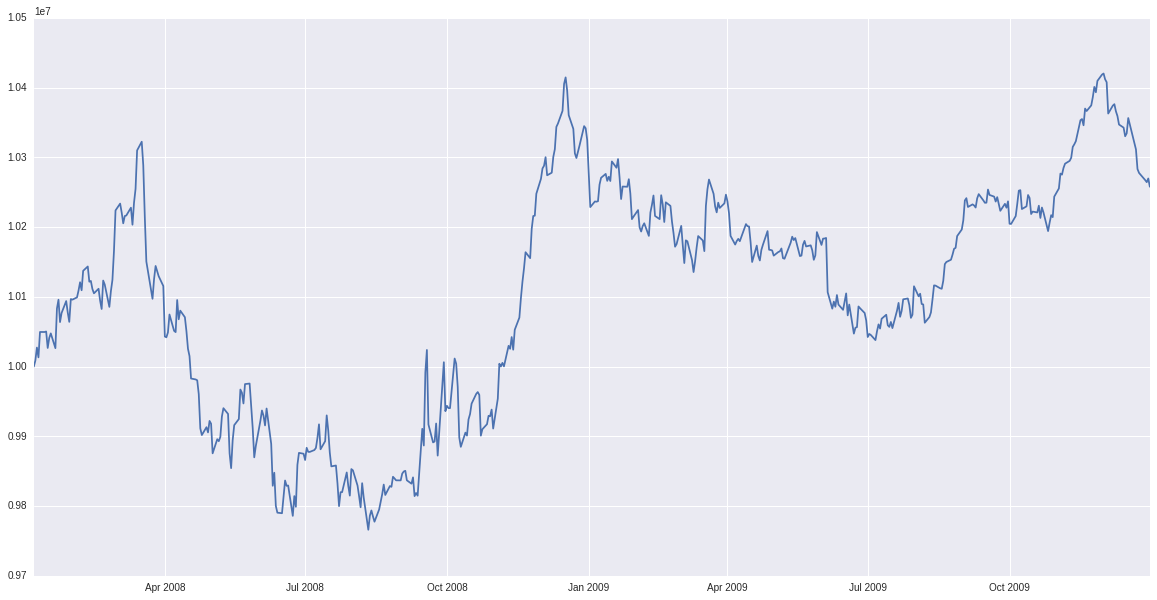

In [14]:
Z,B = sim.sim(U2, sim_FUN=sim.eq_volwt)
B.NAV.plot(figsize=(20,10))

In [15]:
B.Turnover.mean()

0.02704882405155647